# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [ ]:
# KoNLPy 설치
!pip install konlpy

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [18]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 데이터 전처리

In [19]:
# 중복 여부 확인 # 쉐입이 20만 건인데 중복데이터 있는 걸로 판단.
df.shape, df.document.nunique()

((200000, 3), 194543)

In [20]:
# 중복데이터 배제
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [21]:
# Null 데이터 있는지 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [22]:
# Null데이터 제거
df.dropna(how='any', inplace=True)

In [25]:
# 한글이외의 문자를 모두 공백으로 처리하고 strip
df.document = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ' ).str.strip()
df.head(3)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1


In [26]:
# ''만 남은 데이터 --> np.nan 으로 변경시킨 후 제거 
df.document.replace('', np.nan, inplace=True) ## 스트링 리플레이스 아님 주의 
df.document.isna().sum()

1025

In [27]:
# Null 데이터 제거
df.dropna(how='any', inplace=True)
df.shape

(193518, 3)

### 한글 형태소 분석

In [34]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.',',','?','!','\'','"']

In [36]:
okt = Okt()
print(okt.morphs('토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.'))

['토큰', '화가', '된', '상태', '에서는', '각', '리뷰', '의', '길이', '분포', '또한', '확인', '이', '가능합니다', '.']


In [38]:
print(okt.morphs('토큰화가 된 상태에서는, 각 리뷰의 길이 "분포" 또한 확인이 가능합니다.', stem=True))
# 구둣점이 사라지지 않아.

['토큰', '화가', '되다', '상태', '에서는', ',', '각', '리뷰', '의', '길이', '"', '분포', '"', '또한', '확인', '이', '가능하다', '.']


In [41]:
from tqdm.notebook import tqdm

tokenized_data=[]
for sentence in tqdm(df.document):
    morphs = okt.morphs(sentence, stem=True)
    morphs = [word for word in morphs if word not in stopwords]
    tokenized_data.append(morphs)

  0%|          | 0/193518 [00:00<?, ?it/s]

리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 11.04329829783276


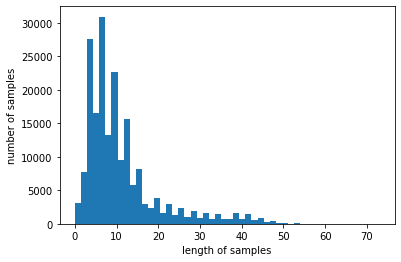

In [42]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec훈련시키기

In [43]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [44]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16376, 100)

In [48]:
model.wv.most_similar("최민식", topn=5)

[('한석규', 0.8781233429908752),
 ('이정재', 0.8485429286956787),
 ('서영희', 0.8473035097122192),
 ('이민호', 0.841891884803772),
 ('안소니', 0.8392150402069092)]

In [49]:
model.wv.most_similar("히어로", topn=5)

[('슬래셔', 0.8695300817489624),
 ('무협', 0.8558989763259888),
 ('호러', 0.8528602123260498),
 ('느와르', 0.8456708192825317),
 ('블록버스터', 0.8209564685821533)]

In [50]:
# 한국에서 도쿄를 더하고 서울을 빼면
model.wv.most_similar(positive=['한국','도쿄'], negative=['서울'], topn=5)

[('저급하다', 0.7013167142868042),
 ('휴먼', 0.6972651481628418),
 ('밀리터리', 0.6914055347442627),
 ('실험영화', 0.6852588653564453),
 ('정석', 0.6847625970840454)]

In [52]:
# 황정민에 멜로를 더하고 느와르를 빼면
model.wv.most_similar(positive=['황정민','멜로'], negative=['느와르'])

[('이동욱', 0.8388543725013733),
 ('유아인', 0.8383867740631104),
 ('신민아', 0.8284662365913391),
 ('송지효', 0.8273565769195557),
 ('성유리', 0.8194904923439026),
 ('아역배우', 0.8165690898895264),
 ('이종석', 0.8148155212402344),
 ('신세경', 0.8134534358978271),
 ('장나라', 0.8122550249099731),
 ('김수로', 0.811663806438446)]